<a href="https://colab.research.google.com/github/CristianMorasso/statistical_project/blob/master/Copia_di_statiscal_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Learning Project: ALFA Dataset Anaysis


In [1]:
# Download the dataset from our git repository hosted on Github
!pip install icecream sktime scikit-learn polars numpy
!rm -rf statiscal_project
!git clone https://github.com/CristianMorasso/statistical_project.git

LEN_DATASET = 45

fatal: destination path 'statistical_project' already exists and is not an empty directory.


In [2]:
# Read the data from the csv files
import numpy as np
import pandas  as pd
import os
from random import shuffle

dataset_dir = "statistical_project/data"
dfs = [] # dataframe list

classToString= {0:"no_failure", 1:"elevator", 2:"engine", 3:"rudder",4:"ailerons"}

stringToClass = {}
for key, value in classToString.items():
  stringToClass[value] = key

series_counter = 0

for _, cl  in enumerate(os.listdir(dataset_dir)):
  path1 = os.path.join(dataset_dir, cl)

  # Get rid of files or bad dirs
  if not os.path.isdir(path1) or cl == "features":
    print(f"{cl} is not a dir or not useful!")
    continue

  for f in  os.listdir(path1):
    pathf = os.path.join(path1, f)
    df = pd.read_csv(pathf)

    # Fix the label field
    try:
      df["field.data"] = df["field.data"].apply(func=lambda x: stringToClass[cl] if int(x)>0 else 0)
      df = df.rename(columns={"field.data": "Y"})
    except:
      print(f"Error for {cl}")
      df["Y"]  = pd.Series([ 0 for _ in range(df.shape[0])])

    # Drop the time column!
    df = df.drop("%time", axis=1)

    # Save it
    dfs.append(df)
    series_counter+=1

print(f"\nNumber of Time Series: {len(dfs)}")
assert len(dfs) == LEN_DATASET # We know the exact number from the repo

# Shuffle the array of dataframes for so that classes are not contiguous
shuffle(dfs)

README.md is not a dir or not useful!
__init__.py is not a dir or not useful!
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
features is not a dir or not useful!

Number of Time Series: 45


### Remove not usable features

In [3]:
from sklearn.impute import SimpleImputer
import numpy as np

# Remove useless features and inpute missing values
#
# finally use the mask on every timeseries of the OG dataframes list

# Remove all the features that are not shared by all Time Series
#
# Only use the variables that can be found in all the dataframes
features = []
# Get the biggest set:
# (We are considering that that the bigger set is just a superset and has all the other base features)
for df in dfs:
   features = max(features, df.columns.values, key=lambda x: len(x))
# Then get the set intersection of all of the features sets
features = set(features)
for df in dfs:
  features = features.intersection(set(df.columns.values))

# Apply the feature mask
print(len(features))
dfs = list(map(lambda x: x[list(features)] , dfs))

# Concat all the time series in as single dataframe for later :)
concatted_dfs = pd.concat(dfs)
concatted_y = concatted_dfs["Y"]
concatted_dfs = concatted_dfs.drop("Y", axis=1)

26


In [4]:
from sklearn.impute import SimpleImputer
import numpy as np

# Inpute the missing values first
dfs = list(map(lambda x: SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(x) , dfs))

### Feature Selection

##### With SelectKBest

In [5]:
# Print the number of nans per per each columns
print(concatted_dfs.isnull().sum())
print(f"Length of Concatted Dataframes: {len(concatted_dfs)}")

delta_z                         59
field.twist.linear.z           143
field.alt_error                 57
field.linear_acceleration.x    291
field.linear_acceleration.y    291
field.orientation.y            291
field.twist.linear.x           143
field.twist.angular.z          143
field.xtrack_error              57
field.orientation.x            291
field.orientation.z            291
field.angular_velocity.z       291
delta_roll_airspeed             60
field.twist.linear.y           143
field.angular_velocity.y       291
delta_pitch                     57
delta_x                         59
field.twist.angular.x          143
field.aspd_error                57
delta_yaw                       57
delta_y                         59
field.angular_velocity.x       291
field.twist.angular.y          143
field.linear_acceleration.z    291
delta_roll                      59
dtype: int64
Length of Concatted Dataframes: 93670


In [6]:
from sklearn.feature_selection import SelectKBest
import numpy as np

# Inpute the nan values to the mean of the other entries value of the same column
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(concatted_dfs)
inp_out = imp.transform(concatted_dfs)

# Get the best 20 features of the dataset
columns_ = concatted_dfs.columns.values
feature_mask= SelectKBest(k=20).fit(inp_out, concatted_y).get_feature_names_out(columns_)

# ( Uses sklearn.feature_selection.f_classify )
print("Feature Mask:")
print(feature_mask)
print(f"Length of Feature Mask: {len(feature_mask)}")

Feature Mask:
['delta_z' 'field.twist.linear.z' 'field.alt_error'
 'field.linear_acceleration.x' 'field.linear_acceleration.y'
 'field.orientation.y' 'field.twist.linear.x' 'field.twist.angular.z'
 'field.xtrack_error' 'field.orientation.x' 'field.orientation.z'
 'field.angular_velocity.z' 'delta_roll_airspeed' 'field.twist.linear.y'
 'delta_pitch' 'field.aspd_error' 'delta_yaw' 'delta_y'
 'field.linear_acceleration.z' 'delta_roll']
Length of Feature Mask: 20


#### With randomForest scores:

In [7]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

def plot_feature_importances(model):
    fig_scale = 0.9
    n_features = len(concatted_dfs.columns) # take the features names from the Concatted DataFrame
    plt.figure(figsize=(7*fig_scale,5.4*fig_scale))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), concatted_dfs.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

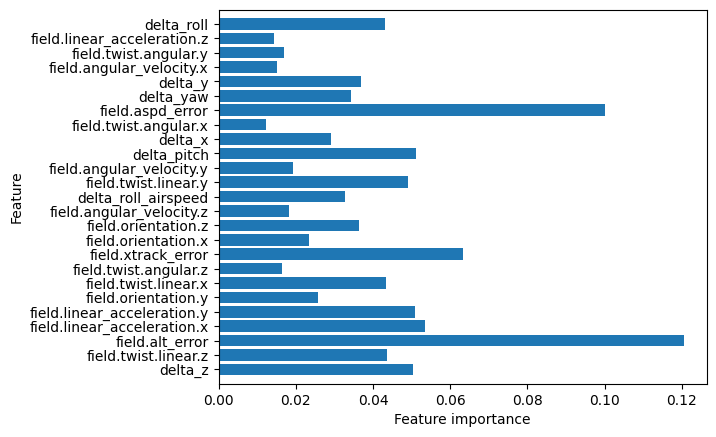

In [8]:
# WITH ERROR COLUMNS:
#
concatted_ndarray = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(concatted_dfs)
rf = RandomForestClassifier()
rf.fit(concatted_ndarray, concatted_y)
# Plot the feature importances
plot_feature_importances(rf)

# Select the n best features
n = 20
feature_mask = list(zip(concatted_dfs.columns, rf.feature_importances_))
feature_mask.sort(key=lambda x: x[1])
feature_mask = list(map(lambda x: x[0], feature_mask[:n]))

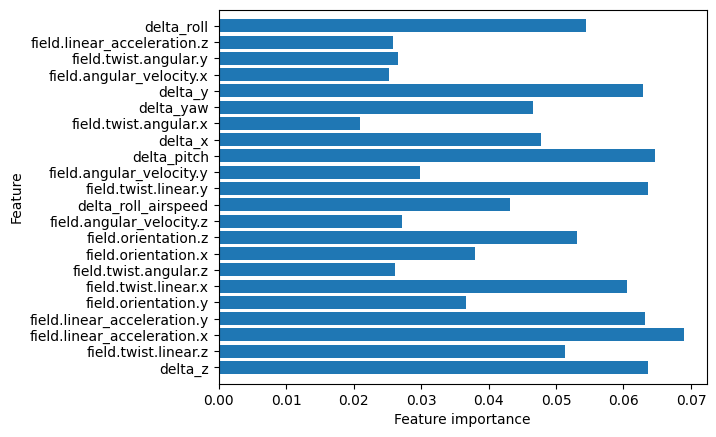

In [9]:
# WITHOUT ERROR COLUMNS:
#
concatted_dfs = concatted_dfs.drop(["field.alt_error", "field.xtrack_error", "field.aspd_error"], axis=1)
concatted_ndarray = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(concatted_dfs)
rf = RandomForestClassifier()
rf.fit(concatted_ndarray, concatted_y)
# Plot the feature importances
plot_feature_importances(rf)
# Select the n best features
n = 20 # Removing 7 (the ones that are clearly not performing (sub 0.03))
feature_mask = list(zip(concatted_dfs.columns, rf.feature_importances_))
feature_mask.sort(key=lambda x: x[1])
feature_mask = list(map(lambda x: x[0], feature_mask[:n]))

### Split the dataset into windows

In [10]:
from sktime.split import SlidingWindowSplitter

splitted_ndarrays, window_length, step_length = [], 10, 10
splitter = SlidingWindowSplitter(window_length=window_length, step_length=step_length)
splitted_ndarrays = [ list(map(lambda x: x[0], splitter.split_series(df))) for df in dfs] # We are ignoring the forecasting horizon

print(f"Length of windowed dataset: {len(splitted_ndarrays)}")
assert len(splitted_ndarrays) == LEN_DATASET

Length of windowed dataset: 45


In [11]:
# Split into windows
_splitted_ndarrays = []
_splitted_ys = []
features = list(features)
y_index = features.index("Y") # Index of the Y column
features.pop(y_index)
#features = ["flight", "step", *features]

i = 0 # Number of windows

for sa in splitted_ndarrays:
  for a in sa:

    # Retrieve the label and save it separately
    _splitted_ys.append(np.max(a[:,y_index]))
    # And then delete it
    a = np.delete(a, y_index, axis=1)

    # np.concatenate([flight, step, a], axis=1)
    _splitted_ndarrays.append(a)
    i+=1 # Increase window counter

assert len(_splitted_ys) == len(_splitted_ndarrays)
print("n_windows",len(_splitted_ndarrays))

n_windows 13336


### Split in Train and set:

In [12]:
import math
from random import shuffle

train_size = int(math.floor(len(_splitted_ndarrays)*0.8))
zipped = list(zip(_splitted_ndarrays, _splitted_ys))
shuffle(zipped)

X_train, X_test = list(map(lambda x: x[0], zipped[:train_size])), list(map(lambda x: x[0], zipped[train_size:]))
y_train, y_test = np.array(list(map(lambda x: x[1], zipped[:train_size]))), np.array(list(map(lambda x: x[1], zipped[train_size:])))

### Multi-Indexed Pandas Dataframe (sktime Panel)

In [13]:
# Finally let's create a multiIndexed pandas.Dataframe so that we can use our data with the sktime library
def toMultiIndexed(windows, feature_mask):
  _dfs = []
  for i, npVals in enumerate(windows):
    d = pd.DataFrame(npVals,columns=feature_mask)
    # The two columns for the multi-indexed Dataframe
    d.insert(0, "flight", [i for _ in range(int(npVals.shape[0]))], True)
    d.insert(1, "step", pd.RangeIndex(int(npVals.shape[0])), True)
    _dfs.append(d)

  _dfs = pd.concat(_dfs)
  # Set the 2 Indexes (onl  y flight is unique)
  _dfs = _dfs.drop_duplicates(subset=['flight', 'step'], keep='last')
  _dfs = _dfs.set_index(["flight", "step"])

  return _dfs

X_train, X_test = toMultiIndexed(X_train, features), toMultiIndexed(X_test, features)

In [14]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
X_train.head(20)

X_train: (106680, 25)
X_test: (26680, 25)
y_train: (10668,)
y_test: (2668,)


delta_z  field.twist.linear.z  field.alt_error  \
flight step                                                    
0      0     0.149597              0.192352        34.680000   
       1     0.081758              0.192352        34.680000   
       2     0.045022              0.192352        34.649998   
       3    -0.019558             -0.037396        34.649998   
       4    -0.019558             -0.037396        34.639999   
       5    -0.079704             -0.037396        34.639999   
       6    -0.101937             -0.037396        34.639999   
       7    -0.157681             -0.037396        34.639999   
       8    -0.251287             -0.037396        34.660000   
       9    -0.354425             -0.251287        34.689999   
1      0     0.090014              0.051541         2.400000   
       1     0.106334              0.051541         2.400000   
       2     0.131125              0.143799         2.410000   
       3     0.176102              0.143799         2.410000   
       4     0.225934              0.143799         2.410000   
       5     0.273864              0.143799         2.410000   
       6     0.358128              0.143799         2.400000   
       7     0.394846              0.424198         2.400000   
       8     0.454925              0.424198         2.380000   
       9     0.518188              0.424198         2.380000   

             field.linear_acceleration.x  field.linear_acceleration.y  \
flight step                                                             
0      0                        0.872792                     0.764919   
       1                        0.872792                     0.764919   
       2                        0.872792                     0.764919   
       3                        0.872792                     0.764919   
       4                        0.872792                     0.764919   
       5                        0.304006                     0.627626   
       6                        0.304006                     0.627626   
       7                        0.304006                     0.627626   
       8                        0.304006                     0.627626   
       9                        0.304006                     0.627626   
1      0                        0.460913                     0.490333   
       1                        0.460913                     0.490333   
       2                        0.460913                     0.490333   
       3                        0.460913                     0.490333   
       4                        0.460913                     0.490333   
       5                        0.460913                     0.490333   
       6                        0.666852                     0.882598   
       7                        0.666852                     0.882598   
       8                        0.666852                     0.882598   
       9                        0.666852                     0.882598   

             field.orientation.y  field.twist.linear.x  field.twist.angular.z  \
flight step                                                                     
0      0               -0.008667             17.326731               0.073682   
       1               -0.008667             17.326731               0.073682   
       2               -0.008667             17.326731               0.073682   
       3               -0.008667             17.360748               0.073682   
       4               -0.008667             17.360748               0.073682   
       5               -0.021049             17.360748               0.073682   
       6               -0.021049             17.360748               0.073682   
       7               -0.021049             17.360748               0.073682   
       8               -0.021049             17.360748               0.073682   
       9               -0.021049             17.414867              -0.017077   
1      0               -0.

# Testing Models:

In [15]:
# List all classifiers in sktime
from sktime.registry import all_estimators
all_estimators("classifier", as_dataframe=True) # , filter_tags={"capability:unequal_length":TrueNN

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

,name,object
0,Arsenal,<class 'sktime.classification.kernel_based._ar...
1,BOSSEnsemble,<class 'sktime.classification.dictionary_based...
2,BOSSVSClassifierPyts,<class 'sktime.classification.dictionary_based...
3,BaggingClassifier,<class 'sktime.classification.ensemble._baggin...
4,CNNClassifier,<class 'sktime.classification.deep_learning.cn...
5,CNTCClassifier,<class 'sktime.classification.deep_learning.cn...
6,CanonicalIntervalForest,<class 'sktime.classification.interval_based._...
7,Catch22Classifier,<class 'sktime.classification.feature_based._c...
8,ClassifierPipeline,<class 'sktime.classification.compose._pipelin...
9,ColumnEnsembleClassifier,<class 'sktime.classification.compose._column_...


In [16]:
from sktime.datatypes import MTYPE_REGISTER
pd.DataFrame(MTYPE_REGISTER)

,0,1,2
0,pd.Series,Series,pd.Series representation of a univariate series
1,pd.DataFrame,Series,pd.DataFrame representation of a uni- or multi...
2,np.ndarray,Series,"2D numpy.ndarray with rows=samples, cols=varia..."
3,xr.DataArray,Series,xr.DataArray representation of a uni- or multi...
4,dask_series,Series,xdas representation of a uni- or multivariate ...
5,nested_univ,Panel,"pd.DataFrame with one column per variable, pd...."
6,numpy3D,Panel,"3D np.array of format (n_instances, n_columns,..."
7,numpyflat,Panel,"WARNING: only for internal use, not a fully su..."
8,pd-multiindex,Panel,"pd.DataFrame with multi-index (instances, time..."
9,pd-wide,Panel,"pd.DataFrame in wide format, cols = (instance*..."


CONVOLUTIONAL NEURAL NETWORK
667/667 [==============================] - 2s 2ms/step
Accuracy: 0.87

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.99      0.93      2243
         1.0       0.00      0.00      0.00         7
         2.0       0.82      0.48      0.61       195
         3.0       0.00      0.00      0.00        24
         4.0       1.00      0.01      0.01       199

    accuracy                           0.87      2668
   macro avg       0.54      0.30      0.31      2668
weighted avg       0.87      0.87      0.82      2668



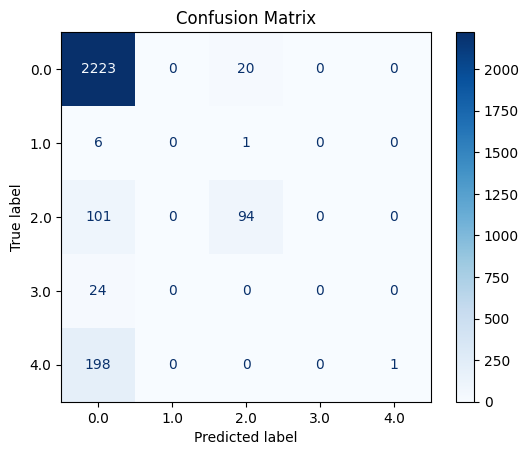

In [21]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.feature_based import RandomIntervalClassifier
from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.datatypes import check_raise
from sklearn.model_selection import LearningCurveDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sktime.transformations.panel.padder import PaddingTransformer
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.transformations.panel.interpolate import TSInterpolator

print("CONVOLUTIONAL NEURAL NETWORK")
cnn = CNNClassifier(n_epochs=50, batch_size=4, kernel_size=3, avg_pool_size=1, n_conv_layers=3, loss='binary_crossentropy')
check_raise(X_train, mtype="pd-multiindex")
check_raise(y_train, mtype='np.ndarray')
cnn.fit(X_train, y_train)

y_pred_cnn = cnn.predict(X_test)

cnn_acc = accuracy_score(y_test, y_pred_cnn)
print(f"Accuracy: {cnn_acc:.2f}")

report = classification_report(y_test, y_pred_cnn, zero_division = 0.0)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

#clf = Pipeline([
#    ("transform", TSInterpolator(50)),
#     ("concatenate", ColumnConcatenator()),
#     ("classify", TimeSeriesForestClassifier(n_estimators=100)),
#    ("transform", PaddingTransformer()),
#    ("classify", RandomIntervalClassifier(n_intervals=10)),
#])
#clf.fit(X_train, y_train)
#clf.score(X_test,y_test)

RECURRENT NEURAL NETWORK
134/134 [==============================] - 0s 2ms/step
Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.99      0.94      2243
         1.0       0.00      0.00      0.00         7
         2.0       0.82      0.67      0.74       195
         3.0       0.81      0.54      0.65        24
         4.0       0.25      0.01      0.01       199

    accuracy                           0.88      2668
   macro avg       0.56      0.44      0.47      2668
weighted avg       0.83      0.88      0.85      2668



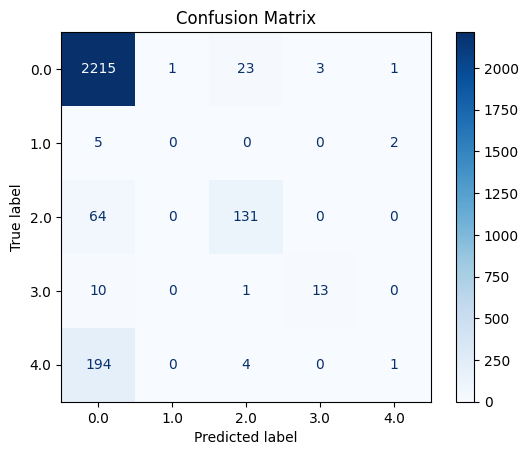

In [22]:
from sktime.classification.deep_learning.rnn import SimpleRNNClassifier

print("RECURRENT NEURAL NETWORK")
rnn = SimpleRNNClassifier(n_epochs=50, batch_size=20, loss='binary_crossentropy')
rnn.fit(X_train, y_train)
# rnn.score(X_test, y_test)

y_pred_rnn = rnn.predict(X_test)

rnn_acc = accuracy_score(y_test, y_pred_rnn)
print(f"Accuracy: {rnn_acc:.2f}")

report = classification_report(y_test, y_pred_rnn, zero_division = 0.0)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_rnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


K-NEIGHBORS


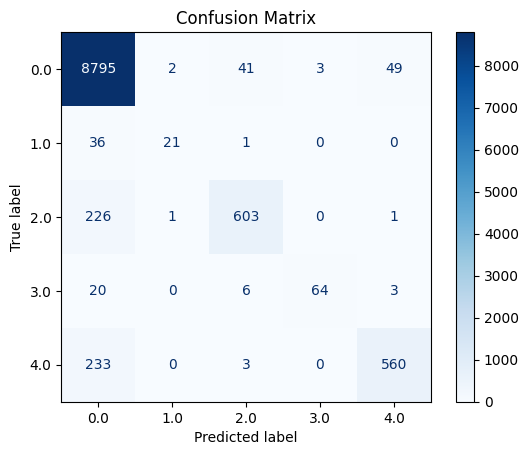

In [24]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

print("K-NEIGHBORS")
knn = KNeighborsTimeSeriesClassifier(n_neighbors=5, distance='dtw')
knn.fit(X_train, y_train)

y_pred_knn_train = knn.predict(X_train)

cm = confusion_matrix(y_train, y_pred_knn_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

K-NEIGHBORS
Accuracy della KNN: 0.90

Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      2243
         1.0       0.00      0.00      0.00         7
         2.0       0.82      0.55      0.66       195
         3.0       0.90      0.79      0.84        24
         4.0       0.73      0.44      0.55       199

    accuracy                           0.90      2668
   macro avg       0.67      0.55      0.60      2668
weighted avg       0.89      0.90      0.89      2668



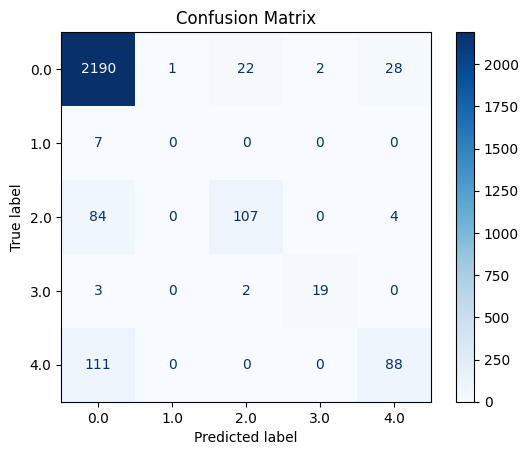

In [23]:
y_pred_knn = knn.predict(X_test)

knn_acc = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy della KNN: {knn_acc:.2f}")

report = classification_report(y_test, y_pred_knn, zero_division = 0.0)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()